## Install and import required libraries

In [2]:
%%capture
# Install required packages
!pip install git+https://github.com/huggingface/transformers
!pip install accelerate
!pip install torch
!pip install pydub
!pip install librosa
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install scikit_learn
!pip install keras
!pip install tensorflow
!pip install huggingface_hub[hf_transfer]

In [3]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import Audio
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, confusion_matrix,roc_auc_score,recall_score,f1_score, ConfusionMatrixDisplay


from pydub import AudioSegment
import math
import keras

import torch
from huggingface_hub import hf_hub_download, snapshot_download
from transformers import AutoModelForCausalLM, AutoProcessor, Qwen2AudioForConditionalGeneration, Qwen2AudioConfig

## Download Qwen2 Audio model and load data

In [5]:
os.environ['HF_HUB_ENABLE_HF_TRANSFER'] = '1'

In [6]:
# Define the model repository ID
repo_id = "Qwen/Qwen2-Audio-7B-Instruct"

# Download the model file using hf_transfer
file_path = snapshot_download(repo_id)

print(f"Model downloaded to: {file_path}")

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.46k [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.28G [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   6%|5         | 220M/3.91G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

Model downloaded to: /root/.cache/huggingface/hub/models--Qwen--Qwen2-Audio-7B-Instruct/snapshots/b825d41106cd5cef971cd2ace8d5349fd2e385ee


In [7]:
# Initialize processor and model
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-Audio-7B-Instruct")
model = Qwen2AudioForConditionalGeneration.from_pretrained(
        "Qwen/Qwen2-Audio-7B-Instruct",
        torch_dtype=torch.float16,
    ).to(device="cuda")

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
print(model)

Qwen2AudioForConditionalGeneration(
  (audio_tower): Qwen2AudioEncoder(
    (conv1): Conv1d(128, 1280, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(1280, 1280, kernel_size=(3,), stride=(2,), padding=(1,))
    (embed_positions): Embedding(1500, 1280)
    (layers): ModuleList(
      (0-31): 32 x Qwen2AudioEncoderLayer(
        (self_attn): Qwen2AudioSdpaAttention(
          (k_proj): Linear(in_features=1280, out_features=1280, bias=False)
          (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=1280, out_features=5120, bias=True)
        (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        (final_layer_norm): Layer

In [9]:
# view default config for model

# Load the model configuration
config = Qwen2AudioConfig.from_pretrained("Qwen/Qwen2-Audio-7B-Instruct")

# Print out the model config
print(config)

Qwen2AudioConfig {
  "architectures": [
    "Qwen2AudioForConditionalGeneration"
  ],
  "audio_config": {
    "model_type": "qwen2_audio_encoder"
  },
  "audio_token_index": 151646,
  "ignore_index": -100,
  "model_type": "qwen2_audio",
  "text_config": {
    "bos_token_id": 151643,
    "eos_token_id": 151645,
    "intermediate_size": 11008,
    "max_position_embeddings": 8192,
    "model_type": "qwen2",
    "rms_norm_eps": 1e-05,
    "torch_dtype": "bfloat16",
    "use_mrope": false,
    "vocab_size": 156032
  },
  "transformers_version": "4.48.0.dev0",
  "vocab_size": 156032
}



In [ ]:
# load in dataframes
train_data = pd.read_csv("/workspace/storage/train_data")
val_data = pd.read_csv("/workspace/storage/val_data")
test_data = pd.read_csv("/workspace/storage/test_data")

# drop the index column
train_data.drop(columns=["Unnamed: 0"], inplace=True)
val_data.drop(columns=["Unnamed: 0"], inplace=True)
test_data.drop(columns=["Unnamed: 0"], inplace=True)

## Test base Qwen2 Audio model

In [10]:
# test base qwen on one audio sample

audio_path = "/workspace/storage/segments/P301_no_silence_segment_2.mp3"

conversation = [
  {'role': 'system', 'content': 'You are a helpful assistant.'},
  {"role": "user", "content": [
      {"type": "audio", "audio_url": audio_path},  # Using local file path
      {"type": "text", "text": "Based on the audio, is the person depressed? Answer with either \"Depressed\" or \"Not Depressed\"."},
  ]},
]
text = processor.apply_chat_template(conversation, add_generation_prompt=True, tokenize=False)
audios = []
for message in conversation:
  if isinstance(message["content"], list):
      for ele in message["content"]:
          if ele["type"] == "audio":
              # Load directly from file path instead of URL
              audios.append(
                  librosa.load(
                      ele['audio_url'],
                      sr=processor.feature_extractor.sampling_rate)[0]
              )

inputs = processor(text=text, audios=audios, return_tensors="pt", padding=True)
inputs = {k: v.to("cuda") if hasattr(v, "to") else v for k, v in inputs.items()}

generate_ids = model.generate(**inputs, max_length=256)
generate_ids = generate_ids[:, inputs['input_ids'].size(1):]

response = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
response

'Depressed'

In [ ]:
# test base qwen on test set
parent_dir = "/workspace/storage/"
base_model_test_results = []

for i, row in test_data.iterrows():
  audio_path = parent_dir + row["Audio Path"]
  true_label = row["Output Label"]

  conversation = [
      {'role': 'system', 'content': 'You are a helpful assistant.'},
      {"role": "user", "content": [
          {"type": "audio", "audio_url": audio_path},  # Using local file path
          {"type": "text", "text": "Based on the audio, is the person depressed? Answer with either \"Depressed\" or \"Not Depressed\"."},
      ]},
  ]
  text = processor.apply_chat_template(conversation, add_generation_prompt=True, tokenize=False)
  audios = []
  for message in conversation:
      if isinstance(message["content"], list):
          for ele in message["content"]:
              if ele["type"] == "audio":
                  # Load directly from file path instead of URL
                  audios.append(
                      librosa.load(
                          ele['audio_url'],
                          sr=processor.feature_extractor.sampling_rate)[0]
                  )

  inputs = processor(text=text, audios=audios, return_tensors="pt", padding=True)
  inputs = {k: v.to("cuda") if hasattr(v, "to") else v for k, v in inputs.items()}

  generate_ids = model.generate(**inputs, max_length=256)
  generate_ids = generate_ids[:, inputs['input_ids'].size(1):]

  response = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
  base_model_test_results.append({'true_label': true_label, 'predicted_label': response, 'audio_path': audio_path})

In [11]:
base_model_test_results[:5]

[{'true_label': 'Depressed',
  'predicted_label': 'Not Depressed',
  'audio_path': '/workspace/storage/segments/segments/P335_no_silence_segment_1.mp3'},
 {'true_label': 'Depressed',
  'predicted_label': 'Not Depressed',
  'audio_path': '/workspace/storage/segments/segments/P335_no_silence_segment_2.mp3'},
 {'true_label': 'Depressed',
  'predicted_label': 'Depressed',
  'audio_path': '/workspace/storage/segments/segments/P335_no_silence_segment_3.mp3'},
 {'true_label': 'Depressed',
  'predicted_label': 'Depressed',
  'audio_path': '/workspace/storage/segments/segments/P335_no_silence_segment_4.mp3'},
 {'true_label': 'Depressed',
  'predicted_label': 'Depressed',
  'audio_path': '/workspace/storage/segments/segments/P335_no_silence_segment_5.mp3'}]

In [ ]:
def eval_model(preds, true_labels, classes):
    print("Accuracy: " + str(sum(1 for x, y in zip(preds, true_labels) if x == y) / len(true_labels)))
    print("AUC Score: " + str(roc_auc_score(true_labels, preds)))
    print("F1 Score: " + str(f1_score(true_labels, preds)))
    print("Recall: " + str(recall_score(true_labels, preds)))

    cm = confusion_matrix(true_labels, preds, labels=[0,1])

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.show()

Accuracy: 0.43028322440087147
AUC Score: 0.5100664498798246
F1 Score: 0.42716319824753557
Recall: 0.7090909090909091


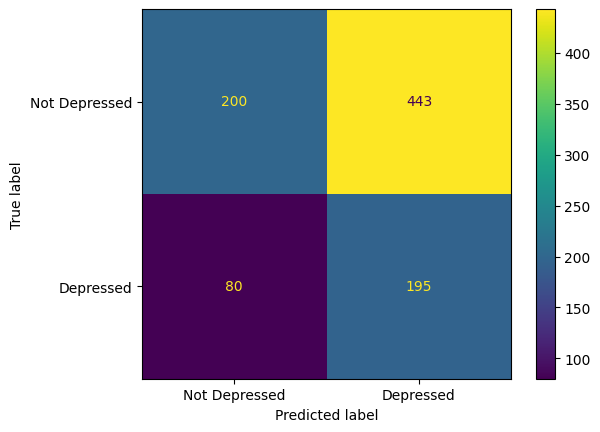

In [ ]:
preds = [1 if row['predicted_label'] == 'Depressed' else 0 for row in base_model_test_results]
true_labels = [1 if row['true_label'] == 'Depressed' else 0 for row in base_model_test_results]
eval_model(preds, true_labels, ['Not Depressed','Depressed'])